# Dog Breed Identification
* Auteurs: Judith Wever, Robbin Dollé, Michiel Flaton
* Datum: 30 juni 2021

## Algemene Imports

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import zipfile
import io
import os
import os.path
import shutil
import random
import gc
from tqdm import tqdm, trange
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
  
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical



## Imports gebruikte modellen

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessor
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocessor
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocessor
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_preprocessor

## Inladen data 
De data wordt ingeladen door het pad aan te geven. De datasets die worden ingeladen zijn: 
- Train_dir: 10222 unieke hondenfoto's met img_id
- Test_dir: 10222 unieke hondenfoto's met img_id 
- Labels: 10222 unieke img_id met hondenrassen die daarbij horen
- Sample_submission: een voorbeeld waarin per rij wordt aangegeven hoe groot de kans is(%) dat een hondenfoto bij elk ras hoort. Hoe hoger het percentage, hoe groter the kans volgens het algoritme. 

### Gebruik
Om het notebook op een eigen computer of server te gebruiken moeten de volgende zaken aanwezig zijn of worden aangepast in de onderstaande 2 cellen:
- Vereist: 16GB RAM en een GPU.
- Als de dataset nog niet is uitgepakt:
    - Uncomment onderstaande cel en pas het pad aan waar je de dataset wilt opslaan in de tweede regel.
    - Zorg dat 'dog-breed-identification.zip' aanwezig is in dezelfde map als dit notebook.
    - Run onderstaande cel (kan een paar minuten duren)
    - Comment onderstaande cel weer
- Zet de paden van *train_dir*, *test_dir*, *labels*, *sample_df* en *features_path* goed afhankelijk van waar je de dataset hebt uitgepakt. *features_path* mag in principe op een locatie naar keuze worden opgeslagen, maar aangeraden wordt dit te doen in de zelfde map als de csv bestanden.
- Het notebook kan nu worden uitgevoerd.

In [3]:
# Uncomment om data uit te pakken
# data = zipfile.ZipFile('dog-breed-identification.zip', 'r')
# data.extractall('../storage')

In [4]:
#PADEN HIER
train_dir = "../storage/train/"
test_dir = "../storage/test/"
labels = pd.read_csv('../storage/labels.csv')
sample_df = pd.read_csv('../storage/sample_submission.csv')
features_path = '../storage/final_features.npy'
test_features_path = '../storage/test_features.npy'

#DIT NIET AANRAKEN
train_paths = glob(train_dir + "*.jpg")
test_paths = glob(test_dir + "*.jpg")

dog_breeds = labels.groupby(['breed']).count().reset_index()['breed']

image_labels = labels.breed
image_ids = labels.id
number_of_samples = len(image_ids)
number_of_breeds = len(dog_breeds)

breed_id_dict = dict(zip(dog_breeds, range(number_of_breeds)))

## Verkennende analyse 
Om meer inzicht te krijgen over de datasets, voeren we verkennende analyse uit. 
Daarvoor gebruiken we 3 functies: 
1. explore_data(): Toont beschrijvende data.   
2. visualize_breed_distribution(): Toont verdeling van rassen 
3. show_sample_imgs(): Toont voorbeeld foto's 

### Beschrijven van de data 
De datasets worden in een dataframe geladen met pandas. Vervolgens wordt de onderstaande informatie opgehaald. 
- Aantal rijen, kolommen
- Eerste en laatste 5 rijen worden getoond. 
- Aantal lege cellen. Wanneer het 0 retourneert, betekend het dat er geen lege waarden zijn. Hierdoor hoeven we geen cellen op te vullen met vergelijkbare waardes.  

In [5]:
def explore_data(df): 
  print(df.shape) 
  print(df.head) 
  print(df.isnull().sum()) 
  unique_count = df.groupby('breed')['id'].nunique()
  print(unique_count)

df2 = labels.assign(img_path=lambda x: train_dir + x['id'] +'.jpg') #train data
df3 = labels.assign(img_path=lambda x: test_dir + x['id'] +'.jpg') #test data 

explore_data(labels) 
explore_data(df2)
explore_data(df3)

del df2, df3

(10222, 2)
<bound method NDFrame.head of                                      id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]>
id       0
breed    0
dtype: int64
breed
affenpinscher                      80
afghan_hound                      116
african_hunting_dog    

# Visualiseren van de data
We willen weten of de verdeling van foto's relatief gelijk zijn aan elkaar in de labels dataset. Als er sprake is van uitschieters, is er verhoogde kans op bias algoritmes. Dit willen we voorkomen. 

De verdeling wordt vormgegeven met een staagdiagram. 
De Y-as toont de rassen en de X-as toont de frequentie per ras. 
conclusie: de verdeling is relatief gelijk verdeeld. We hoeven de dataset qua verdeling niet aan te passen. 

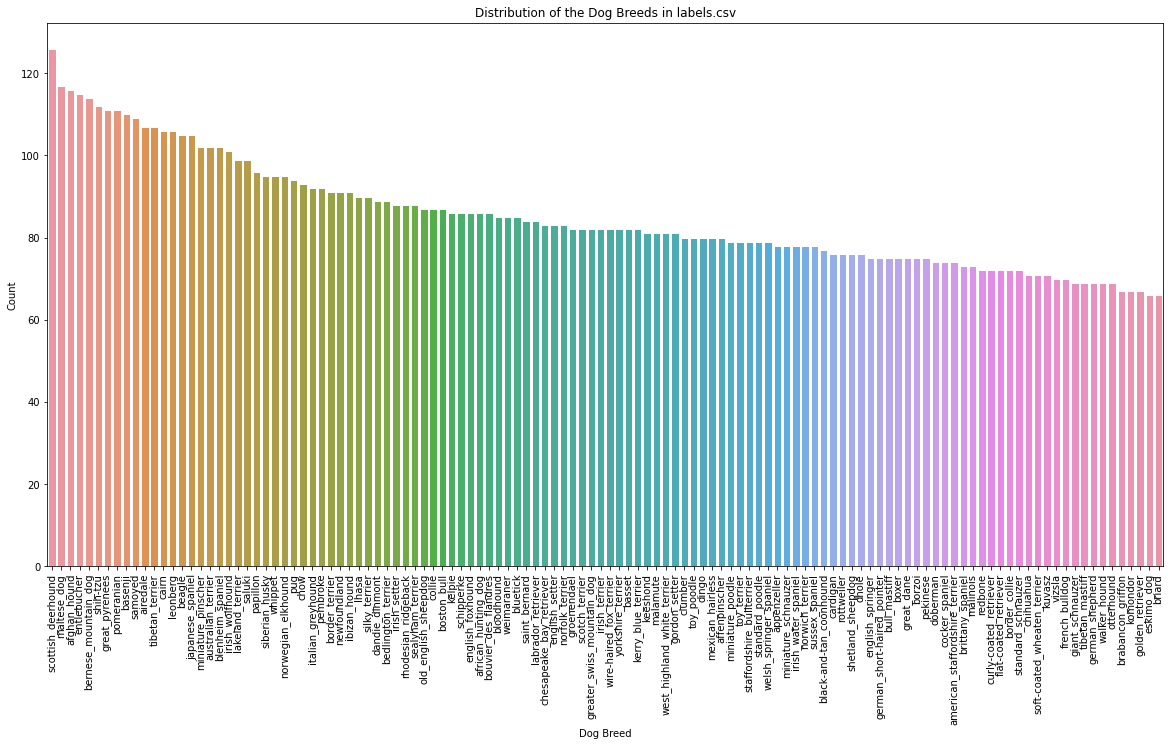

In [6]:
def visualize_breed_distribution(file): 
  fig, ax = plt.subplots()
  fig.set_size_inches(20,10)
  sns.set_style("whitegrid")
  yy = pd.value_counts(labels['breed'])
  ax = sns.barplot(x = yy.index, y = yy, data = labels)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
  ax.set(xlabel='Dog Breed', ylabel='Count')
  ax.set_title('Distribution of the Dog Breeds in labels.csv')

visualize_breed_distribution(labels)

Vervolgens willen we kijken naar de kwaliteit van de fotos van de train dataset. We willen dat alle foto's uniform zijn qua opmaak. We bepalen de kwaliteit van opmaak, door een willekeurige reek van foto's op te halen en in een grafiek te plotten. Met een uniforme opmaak is er een verhoogde kans dat de modellen effectiever getraind worden. Garbage in == Garbage out.  

Conclusie: ze varieren qua formaat, achtergrond, kleur en perspectief. De vervolgstap is de afbeeldingen te bewerken. 

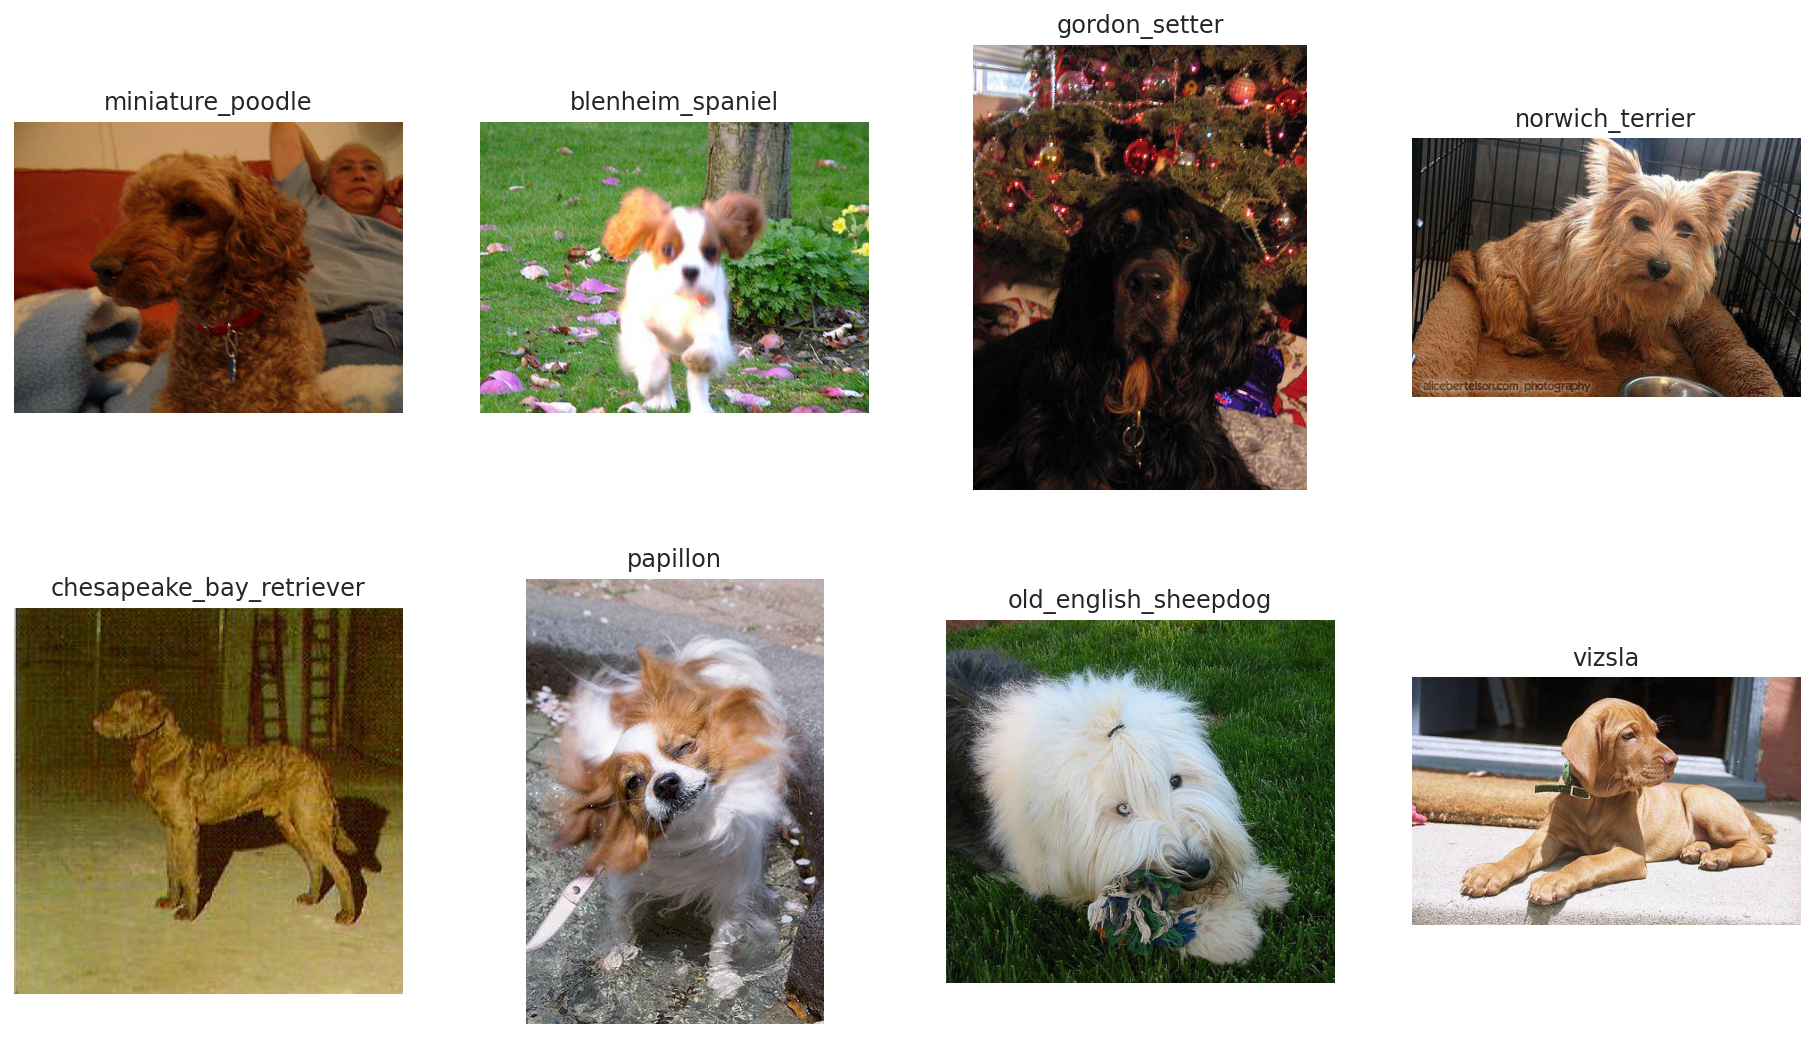

In [7]:
%config InlineBackend.figure_format = 'retina'
    
def show_sample_imgs(image_list): 
    plt.figure(figsize=(16, 9)) #grootte sample imgs
    for i in range(8): #aantal samples  
        random_index = random.randint(0, number_of_samples - 1) #random selectie
        plt.subplot(2, 4, i+1)
        img_path = image_list[random_index]
        img_name = img_path.split('/')[-1].split('.')[0]
        img = mpimg.imread(img_path)
        img_breed = labels[labels['id'] == img_name].breed.values[0]
        plt.imshow(img)
        plt.title(img_breed)
        plt.axis('off')
        
show_sample_imgs(train_paths)

## Inladen Train Data
We halen de train data op uit de train directory en plaatsenn de pixelwaardes in een array.
Om het beste resultaat te garanderen worden alle foto's geschaald naar hetzelfde formaat: 331x331 pixels.



In [8]:
img_size = (331,331,3)

def load_train_data(train_dir, img_size, number_of_samples):
      X = np.zeros([number_of_samples, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
      y = np.zeros([number_of_samples,1], dtype=np.uint8)

      #Itereer met TQDM (trange) voor progress bar. 
      #Laad alle image data van de train set in X en de breed in y
      for i in trange(number_of_samples):
            id = image_ids[i]
            image_path = os.path.join(train_dir, id + '.jpg')
            image_pixels = load_img(image_path, target_size=img_size)
            X[i] = image_pixels
            
            breed = image_labels[i]
            y[i] = breed_id_dict[breed]

      #One-Hot Encoding
      y = to_categorical(y)
      print('Output Data Size: ', X.shape)
      print('Output Label Size: ', y.shape)
      return X, y

## Het Model
Het onderstaande model is ons best presterende model. Tevens zijn er twee andere modellen getraind, welke ter vergelijking verder in het notebook nog worden getoond.

Het gekozen model extraheert features uit vier verschillende voorgetrainde modellen, en gebruikt deze om een Dense Neural Network te trainen.

## Feature extractors

In [9]:
def get_features(model_name, data_preprocessor, input_size, data, batch_size):
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=batch_size, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

def extract_features(img_data, batch_size=64):
    inception_features = get_features(InceptionV3, inception_preprocessor,img_size, img_data, batch_size)
    xception_features = get_features(Xception, xception_preprocessor,img_size, img_data, batch_size)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, img_data, batch_size)
    inc_resnet_features = get_features(InceptionResNetV2, inception_resnet_preprocessor, img_size, img_data, batch_size)
    final_features = np.concatenate([inception_features, xception_features, nasnet_features, inc_resnet_features,], axis=-1)
    
    return final_features

### Extractie Train Features
We controleren of de features al eerder zijn geextraheerd. Als dit het geval is worden deze ingeladen, in plaats van opnieuw de features te berekenen om tijd te besparen. De features zijn namelijk identiek bij iedere run over de zelfde dataset.

Indien de features nog niet zijn geextraheerd gebeurt dat hier, en worden deze vervolgens gelijk weggeschreven naar een bestand voor de volgende run.

In [10]:
X, y = load_train_data(train_dir, img_size, number_of_samples)

if os.path.exists(features_path):
    final_features = np.load(features_path)
    print("Loaded pre-extracted features.")
else:
    print("Pre-extracted features not found. Extracting features.")
    final_features = extract_features(X) 
    print('Final feature maps shape', final_features.shape)
    np.save(features_path, final_features)
    del X


100%|██████████| 10222/10222 [00:50<00:00, 201.52it/s]


Output Data Size:  (10222, 331, 331, 3)
Output Label Size:  (10222, 120)
Loaded pre-extracted features.


## Train DNN
Het DNN wordt getraind met de features. De beste resultaten zijn behaald met de optimizer *adam* en een batch size van 512.
Indien geheugen een bottleneck is kan de batch size worden teruggeschaald naar 64. Dat geeft alleen een iets lagere validation accuracy en een iets hogere validation loss.

Onder ideale omstandigheden wordt een accuracy van 0,9453 en een loss van 0,1724 bereikt op de validatieset.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(number_of_breeds, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model = dnn.fit(final_features, y,
            batch_size=512,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/60
18/18 [==============================] - 1s 35ms/step - loss: 2.9994 - accuracy: 0.4665 - val_loss: 0.2392 - val_accuracy: 0.9404
Epoch 2/60
18/18 [==============================] - 0s 11ms/step - loss: 0.2149 - accuracy: 0.9397 - val_loss: 0.1684 - val_accuracy: 0.9453
Epoch 3/60
18/18 [==============================] - 0s 11ms/step - loss: 0.1611 - accuracy: 0.9494 - val_loss: 0.1648 - val_accuracy: 0.9511
Epoch 4/60
18/18 [==============================] - 0s 11ms/step - loss: 0.1402 - accuracy: 0.9560 - val_loss: 0.1659 - val_accuracy: 0.9501
Epoch 5/60
18/18 [==============================] - 0s 11ms/step - loss: 0.1227 - accuracy: 0.9611 - val_loss: 0.1608 - val_accuracy: 0.9492
Epoch 6/60
18/18 [==============================] - 0s 11ms/step - loss: 0.1058 - accuracy: 0.9660 - val_loss: 0.1620 - val_accuracy: 0.9462
Epoch 7/60
18/18 [==============================] - 0s 10ms/step - loss: 0.0990 - accuracy: 0.9694 - val_loss: 0.1727 - val_accuracy: 0.9531
Epoch 8/60
18

## Test data inladen

In [12]:
def load_test_data(data_dir, labels_dataframe, img_size = (224,224,3)):
    images_names = labels_dataframe['id']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
    print('Output Data Size: ', X.shape)
    return X

## Test features extraheren

In [15]:
if os.path.exists(test_features_path):
    test_features = np.load(test_features_path)
    print("Loaded pre-extracted features.")

else:
    print("Extracting Features...")
    test_data = load_test_data(test_dir, sample_df, img_size)
    test_features = extract_features(test_data)
    del test_data
    print('Final feature maps shape', test_features.shape)
    np.save(test_features_path, test_features)

Loaded pre-extracted features.


## Voorspelling
Nu het model is getraind en de test features bekend zijn kunnen er voorspellingen worden gemaakt.

Dat gebeurt simpelweg door de *predict* functie aan te roepen van ons model, en de resultaten weg te schrijven naar het *sample_df* van de kaggle competitie. 

Het resultaat wordt weggeschreven naar *pred.csv* in de zelfde map als dit notebook.

In [16]:
y_pred = dnn.predict(test_features, batch_size=128)

for b in dog_breeds:
    sample_df[b] = y_pred[:,breed_id_dict[b]]
sample_df.to_csv('pred.csv', index=None)


## Controleer resultaten

In [18]:
probabilities = sample_df.copy()
df = probabilities.drop(columns=['id'])

df['max'] = df.idxmax(axis=1)
probabilities['max'] = df['max']
print(probabilities['max'])

0        japanese_spaniel
1                 samoyed
2          english_setter
3                     pug
4                   lhasa
               ...       
10352     standard_poodle
10353          weimaraner
10354               dhole
10355               lhasa
10356     irish_wolfhound
Name: max, Length: 10357, dtype: object


# Bonus: Voorspel het ras van je eigen hond
Om te kijken of het model ook in de praktijk toepasbaar is doen we een test met de hond van Liv.
We verwachten dat het model het ras van Bram voorspelt als Labrador.

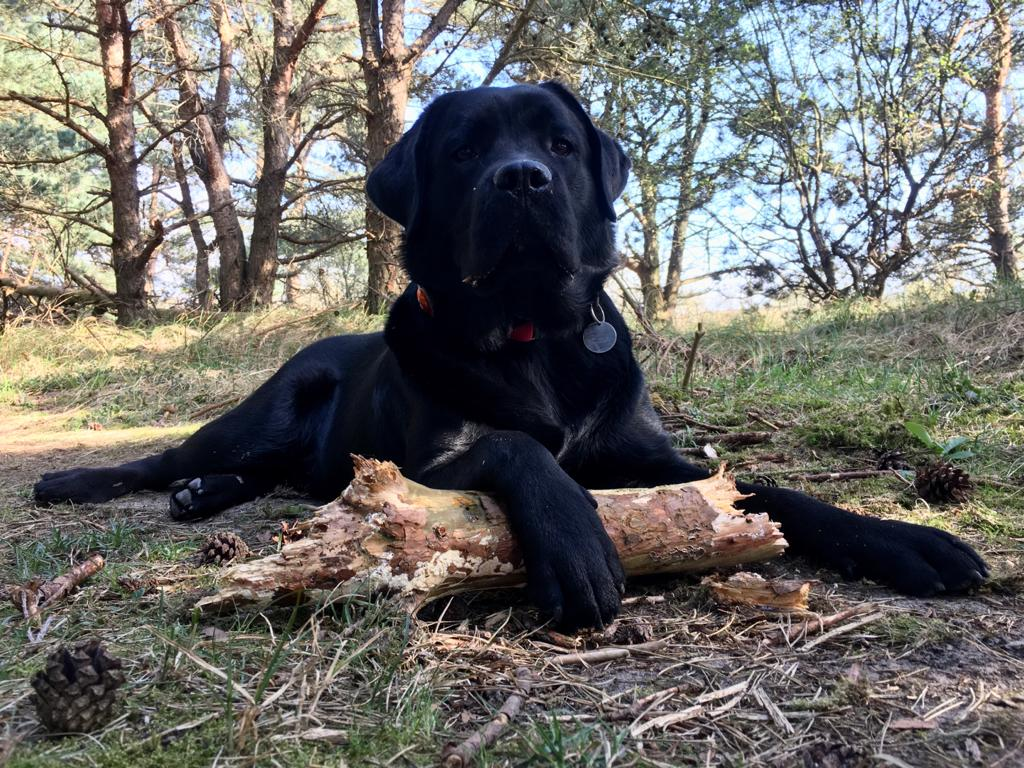

In [20]:
img_path = 'bram.jpg'
Image(img_path)

We laten de foto van Bram in en extraheren zijn features zoals we ook over de test data zouden doen.
Vervolgens laten we het DNN er op los en halen we het ras met de hoogste probability eruit.

In [22]:

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

sample_df = pd.read_csv('../storage/sample_submission.csv')
sample_df = sample_df.drop(columns=['id'])
sample_df = sample_df.iloc[0:0]

def load_single_dog(img_path):
    img_pixels = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    X = np.zeros([1, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    X[0] = img_pixels
    return X


dog = load_single_dog(img_path)
test_features = extract_features(dog, batch_size=1)
y_pred = dnn.predict(test_features, batch_size=1)

sample_df.loc[len(sample_df)] = y_pred[0]
sample_df['max'] = sample_df.idxmax(axis=1)

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 6s 6s/step
Feature maps shape:  (1, 4032)
1/1 [==============================] - 4s 4s/step
Feature maps shape:  (1, 1536)


## Resultaat


In [23]:
from IPython.display import Markdown as md
md(f"# {img_path.split()[0]} is een {sample_df['max'].values[0]}")

# bram.jpg is een labrador_retriever

Correct!

# Alternatief Model
Dit model maakt gebruik van VGG16 voor de pretrained features en CNN Model voor de voorspellingen.


## Imports

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

## Laad train & test data

In [25]:
sample_df = pd.read_csv('../storage/sample_submission.csv')
X, y = load_train_data(train_dir, (224,224,3), number_of_samples)
X_test = load_test_data(test_dir, sample_df, img_size = (224,224,3))

  0%|          | 12/10357 [00:00<01:26, 119.80it/s]

Output Data Size:  (10222, 224, 224, 3)
Output Label Size:  (10222, 120)


100%|██████████| 10357/10357 [00:49<00:00, 208.27it/s]

Output Data Size:  (10357, 224, 224, 3)


## Extraheer Features op Train en Test met VGG16

In [26]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    inputs = Input((224, 224, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [27]:
vgg16_features = get_features(VGG16, X)
vgg16_feature_test = get_features(VGG16, X_test)

162/162 [==============================] - 30s 187ms/step


## Compileer een CNN-model op basis van de VGG16 Features

In [29]:
inputs = Input(vgg16_features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(number_of_breeds, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(vgg16_features, y, batch_size=128, epochs=60, validation_split=0.1, callbacks=my_callback)


Epoch 1/60
72/72 [==============================] - 1s 4ms/step - loss: 25.3432 - accuracy: 0.0204 - val_loss: 6.9617 - val_accuracy: 0.1808
Epoch 2/60
72/72 [==============================] - 0s 2ms/step - loss: 13.7581 - accuracy: 0.1038 - val_loss: 4.1104 - val_accuracy: 0.3695
Epoch 3/60
72/72 [==============================] - 0s 3ms/step - loss: 9.3452 - accuracy: 0.2069 - val_loss: 3.0485 - val_accuracy: 0.4878
Epoch 4/60
72/72 [==============================] - 0s 3ms/step - loss: 7.1572 - accuracy: 0.2879 - val_loss: 2.5421 - val_accuracy: 0.5494
Epoch 5/60
72/72 [==============================] - 0s 3ms/step - loss: 5.6369 - accuracy: 0.3695 - val_loss: 2.3709 - val_accuracy: 0.5777
Epoch 6/60
72/72 [==============================] - 0s 3ms/step - loss: 4.6065 - accuracy: 0.4111 - val_loss: 2.3035 - val_accuracy: 0.5943
Epoch 7/60
72/72 [==============================] - 0s 2ms/step - loss: 4.0547 - accuracy: 0.4583 - val_loss: 2.0949 - val_accuracy: 0.6022
Epoch 8/60
72/72 [

## Validation Accuracy: 0.6598

## Schrijf voorspelling VGG16 + CNN weg

In [30]:
y_pred = model.predict(vgg16_feature_test, batch_size=128)

for b in dog_breeds:
    sample_df[b] = y_pred[:,breed_id_dict[b]]
sample_df.to_csv('pred.csv', index=None)
    
sample_df.to_csv('pred_model2.csv', index=None)

# Extra: Mensen Detectie met Pre-trained face detector
Gezichtsdetectie met behulp van Haar cascades is een op machine learning gebaseerde approach waarbij een cascadefunctie wordt getraind met een set invoergegevens. OpenCV bevat al veel vooraf getrainde classifiers voor gezicht, ogen, glimlachen, etc.. Om mensen te detecteren in de hondenfoto's moeten we de face classifier gebruiken. 

We gebruiken het pre-trained classificatie-XML-bestand (haarcascade_frontalface_default.xml). Deze wordt automatisch gedownload van de GitHub-repository van OpenCv.

**Om gezichten in afbeeldingen te detecteren:**

In [31]:
dog_files = train_paths
df = labels
n_classes = number_of_breeds
class_to_num = breed_id_dict



Number of faces detected: 3


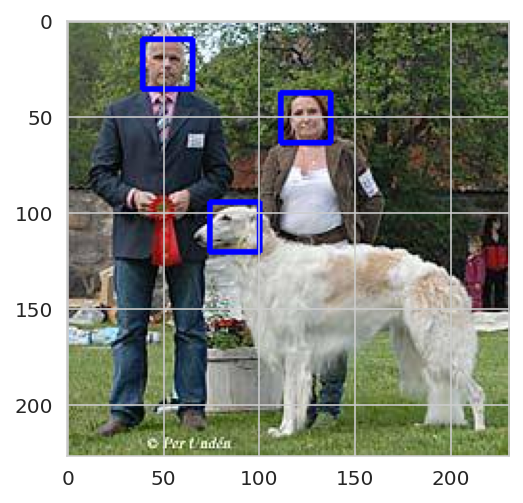

In [33]:
import urllib.request
import cv2

# importeren van pre-trained face detector

url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
document = urllib.request.urlopen (url).read()
f = open("face_detector.xml", "wb")
f.write(document)
f.close()

face_cascade = cv2.CascadeClassifier("face_detector.xml")

# inladen color (BGR) afbeeldingen
img = cv2.imread('../storage/train/002a283a315af96eaea0e28e7163b21b.jpg')

# converteren BGR image naar grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# gezichten detecteren
faces = face_cascade.detectMultiScale(gray)

# aantal gezichten printen
print('Number of faces detected:', len(faces))

# box weergeven om elk gedetecteerde gezicht
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# converteren BGR image naar RGB om te plotten
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# aafbeeldingen weergeven met box
plt.imshow(cv_rgb)
plt.show()

**Onderstaande code test het model van de bovenstaande code op de hondenafbeeldingen (img_path)**

In [35]:
# returns "True" als een gezicht gedetecteerd is van de afbeeldingen in img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

**We geven met de onderstaande cell weer hoeveel procent van de hondenafbeeldingen in de train_dir gezichten van mensen bevatten**

In [37]:
from tqdm import tqdm

dog_files_short = dog_files[:100]


## Testen van algoritme en percentage weergeven van alle gezichten
count_faces = 0

num_files = len(dog_files_short)

for file in dog_files_short:
    if face_detector(file) == True:
        count_faces += 1
        


print('Gezichts herkenning')
print('Percentage van getelde gezichten in de hondenafbeeldingen: {0:.0%}'.format(count_faces / num_files))

Gezichts herkenning
Percentage van getelde gezichten in de hondenafbeeldingen: 30%
